# Анализ эффективности рекламных каналов
Мы работаем с данными компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android.  

Мы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения.  

Мы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

Обратите внимание на следующее:
- В выгрузке только уникальные действия пользователей за каждый день 
- Можно миновать стадию установки приложения, если оно было установлено ранее
- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку. 

Задачи:  
Сделать когортный анализ, и посчитать конверсию в течение 7 дней.  
Построить воронку и найти самые большие точки оттока пользователей. 
Определим рекламный канал:
- с самым большим притоком пользователей 
- с самой низкой конверсией  
- с самым большим первым чеком
- с самым высоким ROMI

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', rc={'figure.figsize': (16,5)})

In [2]:
df = pd.read_csv('KC_case_data.csv', parse_dates=['date'])
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


<hr>

Описание данных:

- date – дата совершения события
- event - событие

app_install – установка приложения  
register – зарегистрироваться  
app_start – открыть приложения  
search – перейти на страницу поиска товаров (каталог)  
choose_item – отправить товар в корзину  
tap_basket – перейти в корзину  
purchase – подтверждение покупки  

- gender – пол пользователя

- os_name – платформа пользователя

- city – город пользователя

- device_id – идентификатор устройства пользователя

- utm_source – канал, с которого пришел пользователь

yandex-direct – Яндекс директ  
google_ads – реклама в Google  
vk_ads – реклама в ВК  
instagram_ads – реклама в instagram  
facebook_ads – реклама в facebook  
referral – акция «приведи друга»  
Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы    

- purchase_sum – стоимость покупки (при совершении события ‘purchase’)

## Считаем конверсию в течение 7 дней
Присвоим пользователям когорты по дню установки приложения и посчитайте для них конверсию из установки в покупку в течение 7 дней.  
Считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

In [3]:
# получаем установки приложения
install = df[df.event == 'app_install'][['date', 'device_id']]
install.columns= ['date','device_id']
install.head()

,date,device_id
2515061,2020-01-01,4921563
2515062,2020-01-01,1311583
2515063,2020-01-01,23006325
2515064,2020-01-01,5645652
2515065,2020-01-01,8798567


In [4]:
# первая покупка
first_purchase = df[df.event == 'purchase'].groupby('device_id').date.min().to_frame().reset_index()
first_purchase.columns = ['device_id', 'first_purchase']
first_purchase.head()

,device_id,first_purchase
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4120,2020-01-07
4,4125,2020-01-07


In [5]:
# объединим данные и посчитаем разницу в днях
data = install.merge(first_purchase, on='device_id', how='left')
data['day'] = (data.first_purchase - data.date).dt.days
data.head()

,date,device_id,first_purchase,day
0,2020-01-01,4921563,2020-01-10,9.0
1,2020-01-01,1311583,NaT,NaN
2,2020-01-01,23006325,2020-01-01,0.0
3,2020-01-01,5645652,NaT,NaN
4,2020-01-01,8798567,NaT,NaN


In [6]:
# считаем размеры когорт
cohorts_size = data.groupby('date').device_id.count().to_frame().reset_index()
cohorts_size.columns = ['cohort', 'size_cohort']
cohorts_size.head()

,cohort,size_cohort
0,2020-01-01,3579
1,2020-01-02,3144
2,2020-01-03,2402
3,2020-01-04,1831
4,2020-01-05,1671


In [7]:
# считаем когорту на каждый день
cohort_by_day = data.groupby(['date', 'day']).device_id.count().reset_index()
cohort_by_day.columns = ['cohort', 'day', 'users']

cohort_by_day.head()

,cohort,day,users
0,2020-01-01,0.0,736
1,2020-01-01,1.0,132
2,2020-01-01,2.0,137
3,2020-01-01,3.0,94
4,2020-01-01,4.0,77


In [8]:
# объединяем когорты на каждый день с размерами когорт
result = cohort_by_day.merge(cohorts_size, on='cohort', how='left')
result['CR'] = result.users * 100 / result.size_cohort
result = result[result.day <= 7]
result.head()

,cohort,day,users,size_cohort,CR
0,2020-01-01,0.0,736,3579,20.564403
1,2020-01-01,1.0,132,3579,3.688181
2,2020-01-01,2.0,137,3579,3.827885
3,2020-01-01,3.0,94,3579,2.626432
4,2020-01-01,4.0,77,3579,2.151439


In [9]:
# строим таблицу для графика
result['cohort'] = result['cohort'].dt.strftime('%Y-%m-%d')
result['day'] = result.day.astype(int).astype(str) + '_day'
table = result[['cohort', 'day', 'CR']] \
    .pivot_table(index='cohort', columns='day', values='CR', aggfunc='sum').cumsum(axis=1).round(2)
table.head()

day,0_day,1_day,2_day,3_day,4_day,5_day,6_day,7_day
cohort,,,,,,,,
2020-01-01,20.56,24.25,28.08,30.71,32.86,35.18,37.16,39.34
2020-01-02,21.69,24.78,27.07,30.09,32.73,34.51,36.07,37.72
2020-01-03,21.77,23.90,27.06,28.43,30.35,31.97,33.10,34.72
2020-01-04,20.97,24.96,26.43,28.35,29.66,31.29,33.10,34.90
2020-01-05,22.56,25.61,27.11,28.90,30.28,31.96,33.27,35.13


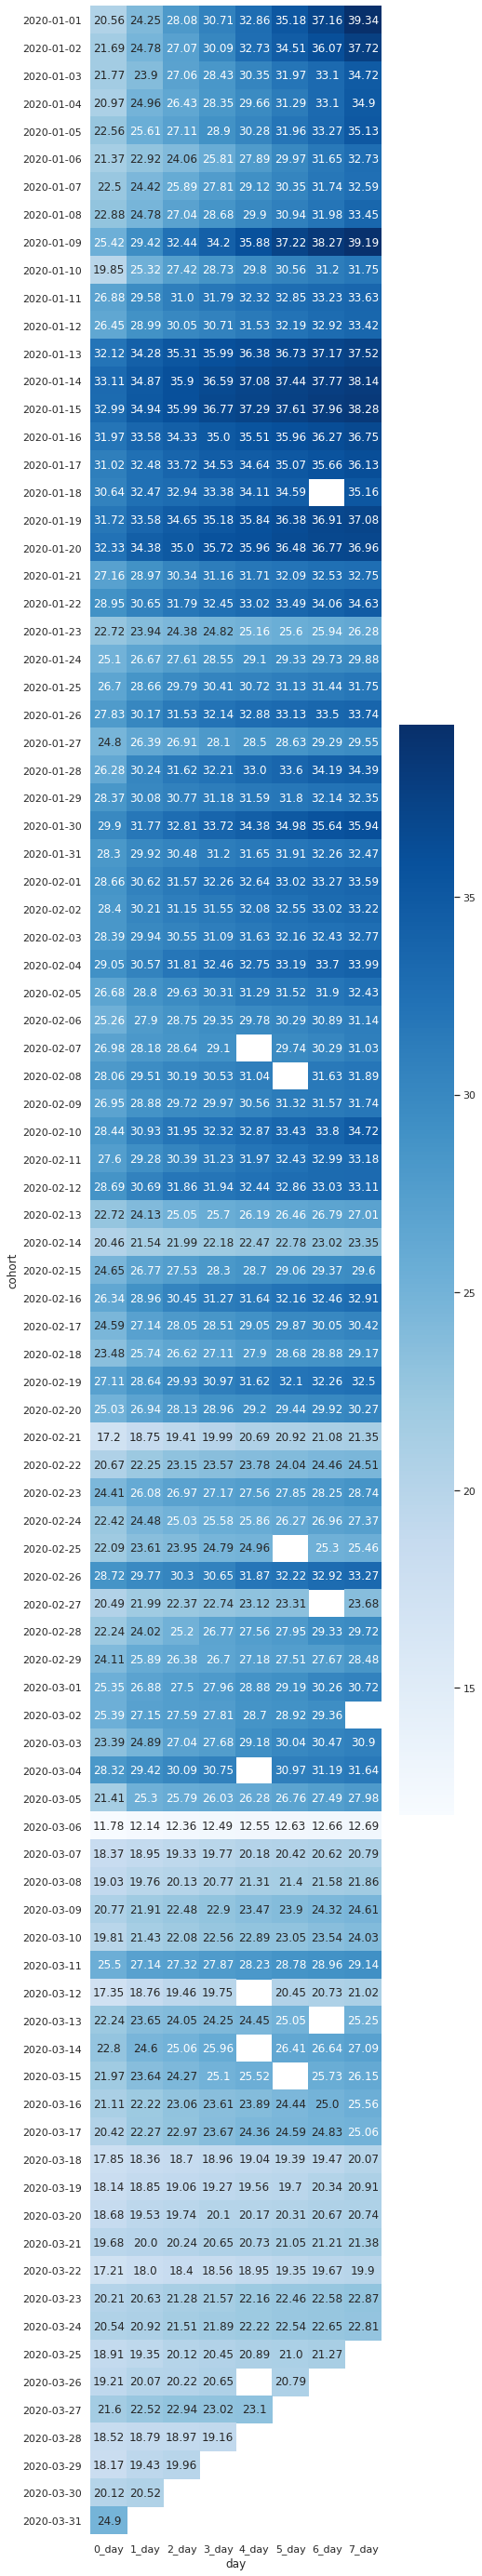

In [10]:
plt.figure(figsize=(7, 50))
sns.heatmap(data=table, fmt='', vmin=table.min().min(), vmax=table.max().max(), annot=True, cmap='Blues')
plt.show()

In [11]:
d = table.reset_index()
max_val = d['7_day'].max()
name_cohort = d.iloc[d['7_day'].idxmax()].cohort
print('Для {} когорты на 7 день конверсия была наибольшей, в размере {}'.format(name_cohort, max_val))

Для 2020-01-01 когорты на 7 день конверсия была наибольшей, в размере 39.34


## Определим  канал с самым большим притоком пользователей
Посмотрим с какого платного маркетингового канала пришло больше всего новых пользователей?  

In [12]:
# новый пользователь подразумевается app_install 
buy = ['yandex-direct', 'google_ads', 'vk_ads', 'instagram_ads', 'facebook_ads']

new_users = df[(df.event == 'app_install') & (df.utm_source.isin(buy))].groupby('device_id') \
    .agg({'utm_source': 'max'}).reset_index()

new_users.utm_source.value_counts().idxmax()

'yandex-direct'

## Построим воронку и найдем самые большие точки оттока
Проанализируем на каком этапе воронки отваливается бОльшая часть клиентов.  
Посмотрим отдельно сценарии для зарегистрированных и для незарегистрированных пользователей.  

In [13]:
# собираем уникальных device_id
data = pd.DataFrame(df.device_id.unique(), columns=['device_id'])
#data.head()

In [14]:
# собираем даты регистрации
register = df[df.event == 'register'][['device_id', 'date']].rename(columns={'date': 'register'})

# добавляем даты регистрации
data = data.merge(register, on='device_id', how='left')
#data.head()

In [15]:
# выбираем дату первого поиска
search = df[df.event == 'search'][['device_id', 'date']].rename(columns={'date': 'search'})
search = search.groupby('device_id').agg({'search': 'min'}).reset_index()

# добавляем даты первого поиска
data = data.merge(search, on='device_id', how='left')
#data.head()

In [16]:
# выбираем дату первого добавления в корзину
choose_item = df[df.event == 'choose_item'][['device_id', 'date']].rename(columns={'date': 'choose_item'})
choose_item = choose_item.groupby('device_id').agg({'choose_item': 'min'}).reset_index()

# добавляем даты первого добавления в корзину
data = data.merge(choose_item, on='device_id', how='left')
#data.head()

In [17]:
# выбираем дату первого перехода в корзину
tap_basket = df[df.event == 'tap_basket'][['device_id', 'date']].rename(columns={'date': 'tap_basket'})
tap_basket = tap_basket.groupby('device_id').agg({'tap_basket': 'min'}).reset_index()

# добавляем даты первого перехода в корзину
data = data.merge(tap_basket, on='device_id', how='left')
#data.head()

In [18]:
# выбираем дату первой покупки
purchase = df[df.event == 'purchase'][['device_id', 'date']].rename(columns={'date': 'purchase'})
purchase = purchase.groupby('device_id').agg({'purchase': 'min'}).reset_index()

# добавляем даты первого перехода в корзину
data = data.merge(purchase, on='device_id', how='left')
data.head()

,device_id,register,search,choose_item,tap_basket,purchase
0,669460,2020-01-07,2020-01-01,2020-01-03,2020-01-03,2020-01-07
1,833621,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
2,1579237,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
3,1737182,2020-01-01,2020-01-01,2020-01-01,2020-01-01,NaT
4,4029024,NaT,2020-01-01,2020-01-01,2020-01-01,NaT


In [19]:
# подсчёт относительного CR
def get_relative_CR(values):
    result = []
    for i in range(len(values)):
        if i < len(values) - 1:
            result.append(100 - round(values[i+1] / values[i] * 100, 2))
        else:
            result.append(0)
    return result

# подсчёт абсолютного CR
def get_absolute_CR(values):
    result = []
    all_ = values[0]
    for i in range(len(values)):
        if i < len(values) - 1:
            result.append(round(abs(values[i+1] - values[i])/ all_ * 100, 2))
        else:
            result.append(0)
    return result

Посмотрим воронки отдельно для зарегистрированных и незарегистрированных пользователей

In [20]:
# сводим данные по не зарегестрированным пользователям
not_registred = data[data.register.isna()][['device_id', 'search', 'choose_item', 'tap_basket']]
not_registred = pd.DataFrame(not_registred.count(), columns=['count'])

# незарегестрированные считаем CR
not_registred['CR_relative'] = get_relative_CR(not_registred['count'].values)
not_registred['CR_absolute'] = get_absolute_CR(not_registred['count'].values)
not_registred

,count,CR_relative,CR_absolute
device_id,112574,5.68,5.68
search,106178,27.12,25.58
choose_item,77381,39.13,26.90
tap_basket,47104,0.00,0.00


In [21]:
# сводим данные по зарегестрированным пользователям
registred = data[data.register.notna()][['device_id', 'register', 'search', 'choose_item', 'tap_basket', 'purchase']]
registred = pd.DataFrame(registred.count(), columns=['count'])

# зарегистрированные считаем CR
registred['CR_relative'] = get_relative_CR(registred['count'].values)
registred['CR_absolute'] = get_absolute_CR(registred['count'].values)
registred

,count,CR_relative,CR_absolute
device_id,78310,0.00,0.00
register,78310,0.00,0.00
search,78310,0.00,0.00
choose_item,78310,0.00,0.00
tap_basket,78310,9.49,9.49
purchase,70875,0.00,0.00


In [22]:
print('На', not_registred.CR_relative.idxmax(), 'шаге отваливается больше всего не зарегистрированных пользователей')

На choose_item шаге отваливается больше всего не зарегистрированных пользователей


In [23]:
print('На', registred.CR_relative.idxmax(), 'шаге отваливается больше всего зарегистрированных пользователей')

На tap_basket шаге отваливается больше всего зарегистрированных пользователей


# Определим каналы с самой низкой конверсией
Выясним, пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?  

CR = кол-во юзеров, впервые совершивших покупку/кол-во юзеров, впервые открывших приложение 

In [24]:
# собираем уникальные utm_source для device_id
utm_source = df[['device_id', 'utm_source']].groupby('device_id').agg({'utm_source': 'min'}).reset_index()
utm_source.head()

# выбираем дату первого запуска
app_start = df[df.event == 'app_start'][['device_id', 'date']].rename(columns={'date': 'app_start'})
app_start = app_start.groupby('device_id').agg({'app_start': 'min'}).reset_index()
app_start.head()

# объединяем данные о покупках и источниках utm_source
data_source = data[['device_id', 'purchase']].merge(utm_source, on='device_id', how='left') \
    .merge(app_start, on='device_id', how='left')

data_source.head()

,device_id,purchase,utm_source,app_start
0,669460,2020-01-07,-,2020-01-01
1,833621,2020-01-01,referal,2020-01-01
2,1579237,2020-01-01,referal,2020-01-01
3,1737182,NaT,facebook_ads,2020-01-01
4,4029024,NaT,facebook_ads,2020-01-01


In [25]:
# группируем данные по источникам
data_source = data_source.groupby('utm_source').agg({'app_start': 'count', 'purchase': 'count'})
data_source.head()

# считаем в отдельной колонке CR
data_source['CR'] = round(data_source.purchase / data_source.app_start * 100, 2)
data_source

,app_start,purchase,CR
utm_source,,,
-,52273,21452,41.04
facebook_ads,23037,9642,41.85
google_ads,32035,11537,36.01
instagram_ads,23774,8964,37.71
referal,11164,4569,40.93
vk_ads,23081,8159,35.35
yandex-direct,25520,6552,25.67


In [26]:
print('Пользователи, пришедшие с', data_source.CR.idxmin(), 'показали самую низкую конверсию в первую покупку')

Пользователи, пришедшие с yandex-direct показали самую низкую конверсию в первую покупку


## Определим канал с самым большим первым чеком
Посмотрим пользователи, пришедшие с какого канала, имеют медианный первый чек выше?

In [27]:
# отбираем данные с покупками 
prepare_data = df[['date', 'purchase_sum', 'device_id', 'utm_source']][df.purchase_sum > 0]
prepare_data.head()

,date,purchase_sum,device_id,utm_source
7691,2020-01-01,265.5,6081155,-
7692,2020-01-01,374.0,77448,yandex-direct
7693,2020-01-01,98.5,7458607,instagram_ads
7694,2020-01-01,304.5,3520947,instagram_ads
7695,2020-01-01,153.5,1170605,google_ads


In [28]:
# отбираем даты первых покупок
data_avg_check = prepare_data.groupby('device_id').agg({'date': 'min'}).reset_index()
data_avg_check.head()

,device_id,date
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4120,2020-01-07
4,4125,2020-01-07


In [29]:
# добавляем данные первых покупок
channels = ['facebook_ads', 'google_ads', 'instagram_ads', 'vk_ads', 'yandex-direct', 'referal']
data_avg_check = data_avg_check.merge(prepare_data, on=['device_id', 'date'], how='left')
data_avg_check = data_avg_check[data_avg_check.utm_source.isin(channels)]
data_avg_check.head()

,device_id,date,purchase_sum,utm_source
0,4014,2020-02-01,86.0,referal
2,4060,2020-03-07,172.5,yandex-direct
3,4120,2020-01-07,598.5,instagram_ads
4,4125,2020-01-07,566.0,yandex-direct
6,4211,2020-01-24,606.5,facebook_ads


In [30]:
# находим медианный чек
data_avg_check = data_avg_check.groupby('utm_source').agg({'purchase_sum': 'median'}).round()
data_avg_check.head()

,purchase_sum
utm_source,
facebook_ads,389.0
google_ads,390.0
instagram_ads,394.0
referal,396.0
vk_ads,393.0


In [31]:
print('Пользователи, пришедшие с', data_avg_check.purchase_sum.idxmax(), 'имеют медианный первый чек выше')

Пользователи, пришедшие с referal имеют медианный первый чек выше


## Определим канал с самым высоким ROMI
Данные по затратам на рекламу:

Яндекс – 10 491 707 руб.  
Гугл – 10 534 878 руб.  
Фейсбук – 8 590 498 руб.  
Инстаграм – 8 561626 руб.  
ВК – 9 553 531руб.

Расходы на реферальную программу: если пользователь приведет друга и последний совершит первую покупку, то оба получат по 100 рублей.

Посмотрим какой платный канал привлечения (среди рекламных) имеет самый высокий ROMI

In [32]:
# получим данные о прибыли
sources = ['yandex-direct', 'google_ads', 'vk_ads', 'facebook_ads', 'instagram_ads']
gm = df[['purchase_sum', 'utm_source']][df.utm_source.isin(sources)] \
    .groupby('utm_source').agg({'purchase_sum': 'sum'}).rename(columns={'purchase_sum': 'GM'})
gm

,GM
utm_source,
facebook_ads,12249901.0
google_ads,12868276.0
instagram_ads,14546969.0
vk_ads,16389652.5
yandex-direct,13915368.0


In [33]:
# записываем данные о расходах
spend = pd.DataFrame({'yandex-direct': 10491707, 'google_ads': 10534878, 'facebook_ads': 8590498, \
    'instagram_ads': 8561626, 'vk_ads': 9553531}, index=['marketing'])

# собираем GM(gross margin) и  расходы на marketing
levels = pd.concat([gm.T, spend]).T

# считаем ROMI
levels['ROMI'] = (levels.GM - levels.marketing) / levels.marketing
levels

,GM,marketing,ROMI
facebook_ads,12249901.0,8590498.0,0.425983
google_ads,12868276.0,10534878.0,0.221493
instagram_ads,14546969.0,8561626.0,0.699090
vk_ads,16389652.5,9553531.0,0.715560
yandex-direct,13915368.0,10491707.0,0.326321


In [34]:
print('Платный канал привлечения (среди рекламных)', levels.ROMI.idxmax(), 'имеет самый высокий ROMI')

Платный канал привлечения (среди рекламных) vk_ads имеет самый высокий ROMI
